In [13]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model

class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(input_shape)     ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = Dense(cf["hidden_dim"])(inputs)   ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    embed = patch_embed + pos_embed ## (None, 256, 768)

    """ Adding Class Token """
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed]) ## (None, 257, 768)

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    """ Classification Head """
    x = LayerNormalization()(x)     ## (None, 257, 768)
    x = x[:, 0, :]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model


if __name__ == "__main__":
    config = {}
    config["num_layers"] = 24
#     config["hidden_dim"] = 768
#     config["mlp_dim"] =3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 32
    config["num_channels"] = 3
    config["num_classes"] = 3

    config["hidden_dim"] = 256
    config["mlp_dim"] = 1024  

    model = ViT(config)
    model.summary()



Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 256, 3072)]          0         []                            
                                                                                                  
 dense_700 (Dense)           (None, 256, 256)             786688    ['input_15[0][0]']            
                                                                                                  
 tf.__operators__.add_19 (T  (None, 256, 256)             0         ['dense_700[0][0]']           
 FOpLambda)                                                                                       
                                                                                                  
 class_token_40 (ClassToken  (None, 1, 256)               256       ['tf.__operators__.add_

 layer_normalization_691 (L  (None, 257, 256)             512       ['add_676[0][0]']             
 ayerNormalization)                                                                               
                                                                                                  
 dense_705 (Dense)           (None, 257, 1024)            263168    ['layer_normalization_691[0][0
                                                                    ]']                           
                                                                                                  
 dropout_1300 (Dropout)      (None, 257, 1024)            0         ['dense_705[0][0]']           
                                                                                                  
 dense_706 (Dense)           (None, 257, 256)             262400    ['dropout_1300[0][0]']        
                                                                                                  
 dropout_1

                                                                                                  
 dense_711 (Dense)           (None, 257, 1024)            263168    ['layer_normalization_697[0][0
                                                                    ]']                           
                                                                                                  
 dropout_1306 (Dropout)      (None, 257, 1024)            0         ['dense_711[0][0]']           
                                                                                                  
 dense_712 (Dense)           (None, 257, 256)             262400    ['dropout_1306[0][0]']        
                                                                                                  
 dropout_1307 (Dropout)      (None, 257, 256)             0         ['dense_712[0][0]']           
                                                                                                  
 add_683 (

                                                                    ]']                           
                                                                                                  
 dropout_1312 (Dropout)      (None, 257, 1024)            0         ['dense_717[0][0]']           
                                                                                                  
 dense_718 (Dense)           (None, 257, 256)             262400    ['dropout_1312[0][0]']        
                                                                                                  
 dropout_1313 (Dropout)      (None, 257, 256)             0         ['dense_718[0][0]']           
                                                                                                  
 add_689 (Add)               (None, 257, 256)             0         ['dropout_1313[0][0]',        
                                                                     'add_688[0][0]']             
          

 dropout_1318 (Dropout)      (None, 257, 1024)            0         ['dense_723[0][0]']           
                                                                                                  
 dense_724 (Dense)           (None, 257, 256)             262400    ['dropout_1318[0][0]']        
                                                                                                  
 dropout_1319 (Dropout)      (None, 257, 256)             0         ['dense_724[0][0]']           
                                                                                                  
 add_695 (Add)               (None, 257, 256)             0         ['dropout_1319[0][0]',        
                                                                     'add_694[0][0]']             
                                                                                                  
 layer_normalization_710 (L  (None, 257, 256)             512       ['add_695[0][0]']             
 ayerNorma

 dense_730 (Dense)           (None, 257, 256)             262400    ['dropout_1324[0][0]']        
                                                                                                  
 dropout_1325 (Dropout)      (None, 257, 256)             0         ['dense_730[0][0]']           
                                                                                                  
 add_701 (Add)               (None, 257, 256)             0         ['dropout_1325[0][0]',        
                                                                     'add_700[0][0]']             
                                                                                                  
 layer_normalization_716 (L  (None, 257, 256)             512       ['add_701[0][0]']             
 ayerNormalization)                                                                               
                                                                                                  
 multi_hea

 dropout_1331 (Dropout)      (None, 257, 256)             0         ['dense_736[0][0]']           
                                                                                                  
 add_707 (Add)               (None, 257, 256)             0         ['dropout_1331[0][0]',        
                                                                     'add_706[0][0]']             
                                                                                                  
 layer_normalization_722 (L  (None, 257, 256)             512       ['add_707[0][0]']             
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_354 (  (None, 257, 256)             3155200   ['layer_normalization_722[0][0
 MultiHeadAttention)                                                ]',                           
          

 add_713 (Add)               (None, 257, 256)             0         ['dropout_1337[0][0]',        
                                                                     'add_712[0][0]']             
                                                                                                  
 layer_normalization_728 (L  (None, 257, 256)             512       ['add_713[0][0]']             
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_357 (  (None, 257, 256)             3155200   ['layer_normalization_728[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_728[0][0
                                                                    ]']                           
          

                                                                                                  
 layer_normalization_734 (L  (None, 257, 256)             512       ['add_719[0][0]']             
 ayerNormalization)                                                                               
                                                                                                  
 tf.__operators__.getitem_1  (None, 256)                  0         ['layer_normalization_734[0][0
 9 (SlicingOpLambda)                                                ]']                           
                                                                                                  
 dense_749 (Dense)           (None, 3)                    771       ['tf.__operators__.getitem_19[
                                                                    0][0]']                       
                                                                                                  
Total para

Train: 63 - Valid: 21 - Test: 21
Train: 63 - Valid: 21 - Test: 21
Training for fold 1 ...
2
5/5 [==============================] - ETA: 0s - loss: 3.7172 - acc: 0.2985 - auc: 0.4858
Epoch 1: val_loss improved from inf to 1.73207, saving model to files/modelN_fold1.h5


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 97s 8s/step - loss: 3.7172 - acc: 0.2985 - auc: 0.4858 - val_loss: 1.7321 - val_acc: 0.1765 - val_auc: 0.7984 - lr: 1.0000e-04
3
Training for fold 2 ...
2
5/5 [==============================] - ETA: 0s - loss: 3.1043 - acc: 0.4627 - auc: 0.6007
Epoch 1: val_loss improved from inf to 2.17573, saving model to files/modelN_fold2.h5
5/5 [==============================] - 96s 7s/step - loss: 3.1043 - acc: 0.4627 - auc: 0.6007 - val_loss: 2.1757 - val_acc: 0.3529 - val_auc: 0.6939 - lr: 1.0000e-04
3
Training for fold 3 ...
2
5/5 [==============================] - ETA: 0s - loss: 3.2526 - acc: 0.3881 - auc: 0.5455
Epoch 1: val_loss improved from inf to 2.94492, saving model to files/modelN_fold3.h5
5/5 [==============================] - 91s 7s/step - loss: 3.2526 - acc: 0.3881 - auc: 0.5455 - val_loss: 2.9449 - val_acc: 0.2941 - val_auc: 0.8074 - lr: 1.0000e-04
3
Training for fold 4 ...
2
5/5 [==============================] - ETA: 0s - loss: 3.7242 - ac

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


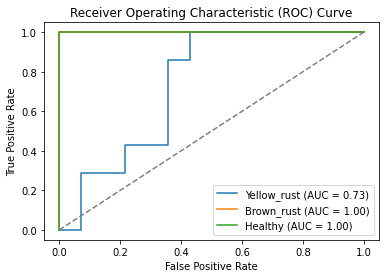

In [10]:
# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/drive/')
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from patchify import patchify
# import tensorflow_hub as hub
# Assuming you have already imported or defined the ViT model
# ...
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#from project import ViT
hp = {
    "image_size": 512,
    "num_channels": 3,
    "patch_size": 64,
    "num_classes": 3,
    "class_names": ["Yellow_rust","Brown_rust", "Healthy"],
    "num_layers": 24,
    "hidden_dim": 256,
    "mlp_dim": 1024,
    "num_heads": 4,
    "dropout_rate": 0.1,
    "batch_size": 16,
    "lr": 1e-4,
    "num_epochs": 1
}
hp["num_patches"] = (hp["image_size"] ** 2) // (hp["patch_size"] ** 2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"] * hp["patch_size"] * hp["num_channels"])


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def load_data(path, split=0.20):
    images = glob(os.path.join(path, "*", "*.jpg"))

    # Separate images by class
    images_class_BKL = [image for image in images if "Yellow_rust" in image]
    images_class_NV = [image for image in images if "Brown_rust" in image]
    images_class_MEL2 = [image for image in images if "Healthy" in image]

    # Oversample to 33,000 to match the largest class (BKL)
    target_size = len(images_class_BKL)
    #print(images_class_BKL)
    images_class_NV = np.random.choice(images_class_NV, size=target_size, replace=True).tolist()
    images_class_MEL2 = np.random.choice(images_class_MEL2, size=target_size, replace=True).tolist()

    # Concatenate lists again and shuffle
    images = shuffle(images_class_BKL + images_class_NV + images_class_MEL2)

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    return train_x, valid_x, test_x


def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image / 255.0

    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])
    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    return patches, class_idx


def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels


def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


def get_model():
    model = ViT(hp)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
        metrics=["acc", AUC(name='auc', multi_label=True)]
    )
    return model


if __name__ == "__main__":
    create_dir("files")
    dataset_path = '/home/ali/Music/PYTHON/DS'
    model_path = os.path.join("files", "model3.h5")
    csv_path = os.path.join("files", "log2.csv")
    train_x, valid_x, test_x = load_data(dataset_path)
    images = train_x + valid_x
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1

    for train, val in kfold.split(images):
        print(f'Training for fold {fold_no} ...')
        train_ds = tf_dataset(np.array(images)[train], batch=hp["batch_size"])
        valid_ds = tf_dataset(np.array(images)[val], batch=hp["batch_size"])
        model = get_model()
        callbacks = [
            ModelCheckpoint(f"files/modelN_fold{fold_no}.h5", monitor='val_loss', verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
            CSVLogger(f"files/log2_fold{fold_no}.csv"),
            EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
        ]
        print(2)
        model.fit(train_ds, epochs=hp["num_epochs"], validation_data=valid_ds, callbacks=callbacks)
        fold_no += 1
        print(3)

    # Evaluating on the test set
    print("Evaluating the test set...")
    test_ds = tf_dataset(test_x, batch=hp["batch_size"])
    all_preds = []
    custom_objects = {"ClassToken": ClassToken}
    for fold_no in range(1, 6):
        with tf.keras.utils.custom_object_scope(custom_objects):
            fold_model = tf.keras.models.load_model(f"files/modelN_fold{fold_no}.h5")
        y_pred_probs = fold_model.predict(test_ds)
        all_preds.append(y_pred_probs)

    avg_preds = np.mean(all_preds, axis=0)
    final_preds = np.argmax(avg_preds, axis=1)
    y_true = [hp["class_names"].index(img.split("/")[-2]) for img in test_x]
    print(classification_report(y_true, final_preds, target_names=hp["class_names"]))
    roc_aucs = []

    for i, class_name in enumerate(hp["class_names"]):
        auc_val = roc_auc_score((np.array(y_true) == i).astype(int), avg_preds[:, i])
        roc_aucs.append(auc_val)
        print(f"AUC-ROC ({class_name}): {auc_val:.4f}")

    for i, class_name in enumerate(hp["class_names"]):
        fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), avg_preds[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_aucs[i]:.2f})")

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Train: 2083 - Valid: 694 - Test: 694
Train: 2083 - Valid: 694 - Test: 694
Training for fold 1 ...
2
139/139 [==============================] - ETA: 0s - loss: 1.2528 - acc: 0.3679 - auc: 0.5354
Epoch 1: val_loss improved from inf to 1.17410, saving model to files/modelN_fold1.h5


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/139 [==============================] - 1017s 7s/step - loss: 1.2528 - acc: 0.3679 - auc: 0.5354 - val_loss: 1.1741 - val_acc: 0.3129 - val_auc: 0.7422 - lr: 1.0000e-04
3
Training for fold 2 ...
2
139/139 [==============================] - ETA: 0s - loss: 1.2627 - acc: 0.3543 - auc: 0.5284
Epoch 1: val_loss improved from inf to 1.02183, saving model to files/modelN_fold2.h5
139/139 [==============================] - 1017s 7s/step - loss: 1.2627 - acc: 0.3543 - auc: 0.5284 - val_loss: 1.0218 - val_acc: 0.4227 - val_auc: 0.7840 - lr: 1.0000e-04
3
Training for fold 3 ...
2
139/139 [==============================] - ETA: 0s - loss: 1.1983 - acc: 0.3947 - auc: 0.5605
Epoch 1: val_loss improved from inf to 0.81027, saving model to files/modelN_fold3.h5
139/139 [==============================] - 1013s 7s/step - loss: 1.1983 - acc: 0.3947 - auc: 0.5605 - val_loss: 0.8103 - val_acc: 0.6450 - val_auc: 0.8551 - lr: 1.0000e-04
3
Training for fold 4 ...
2
139/139 [==============================]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Yellow_rust       0.00      0.00      0.00       218
  Brown_rust       0.95      0.41      0.57       218
     Healthy       0.43      1.00      0.60       258

    accuracy                           0.50       694
   macro avg       0.46      0.47      0.39       694
weighted avg       0.46      0.50      0.40       694

AUC-ROC (Yellow_rust): 0.8322
AUC-ROC (Brown_rust): 0.8680
AUC-ROC (Healthy): 0.8785


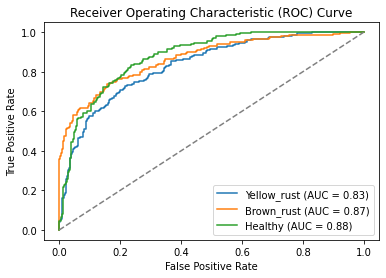

In [14]:
# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/drive/')
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from patchify import patchify
# import tensorflow_hub as hub
# Assuming you have already imported or defined the ViT model
# ...
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#from project import ViT
hp = {
    "image_size": 512,
    "num_channels": 3,
    "patch_size": 64,
    "num_classes": 3,
    "class_names": ["Yellow_rust","Brown_rust", "Healthy"],
    "num_layers": 24,
    "hidden_dim": 256,
    "mlp_dim": 1024,
    "num_heads": 4,
    "dropout_rate": 0.1,
    "batch_size": 16,
    "lr": 1e-4,
    "num_epochs": 1
}
hp["num_patches"] = (hp["image_size"] ** 2) // (hp["patch_size"] ** 2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"] * hp["patch_size"] * hp["num_channels"])


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def load_data(path, split=0.20):
    images = glob(os.path.join(path, "*", "*.jpg"))

    # Separate images by class
    images_class_BKL = [image for image in images if "Yellow_rust" in image]
    images_class_NV = [image for image in images if "Brown_rust" in image]
    images_class_MEL2 = [image for image in images if "Healthy" in image]

    # Oversample to 33,000 to match the largest class (BKL)
    target_size = len(images_class_BKL)
    #print(images_class_BKL)
    images_class_NV = np.random.choice(images_class_NV, size=target_size, replace=True).tolist()
    images_class_MEL2 = np.random.choice(images_class_MEL2, size=target_size, replace=True).tolist()

    # Concatenate lists again and shuffle
    images = shuffle(images_class_BKL + images_class_NV + images_class_MEL2)

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    return train_x, valid_x, test_x


def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image / 255.0

    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])
    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    return patches, class_idx


def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels


def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


def get_model():
    model = ViT(hp)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
        metrics=["acc", AUC(name='auc', multi_label=True)]
    )
    return model


if __name__ == "__main__":
    create_dir("files")
    dataset_path = '/home/ali/Music/PYTHON/WholeDataset'
    model_path = os.path.join("files", "model3.h5")
    csv_path = os.path.join("files", "log2.csv")
    train_x, valid_x, test_x = load_data(dataset_path)
    images = train_x + valid_x
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1

    for train, val in kfold.split(images):
        print(f'Training for fold {fold_no} ...')
        train_ds = tf_dataset(np.array(images)[train], batch=hp["batch_size"])
        valid_ds = tf_dataset(np.array(images)[val], batch=hp["batch_size"])
        model = get_model()
        callbacks = [
            ModelCheckpoint(f"files/modelN_fold{fold_no}.h5", monitor='val_loss', verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
            CSVLogger(f"files/log2_fold{fold_no}.csv"),
            EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
        ]
        print(2)
        model.fit(train_ds, epochs=hp["num_epochs"], validation_data=valid_ds, callbacks=callbacks)
        fold_no += 1
        print(3)

    # Evaluating on the test set
    print("Evaluating the test set...")
    test_ds = tf_dataset(test_x, batch=hp["batch_size"])
    all_preds = []
    custom_objects = {"ClassToken": ClassToken}
    for fold_no in range(1, 6):
        with tf.keras.utils.custom_object_scope(custom_objects):
            fold_model = tf.keras.models.load_model(f"files/modelN_fold{fold_no}.h5")
        y_pred_probs = fold_model.predict(test_ds)
        all_preds.append(y_pred_probs)

    avg_preds = np.mean(all_preds, axis=0)
    final_preds = np.argmax(avg_preds, axis=1)
    y_true = [hp["class_names"].index(img.split("/")[-2]) for img in test_x]
    print(classification_report(y_true, final_preds, target_names=hp["class_names"]))
    roc_aucs = []

    for i, class_name in enumerate(hp["class_names"]):
        auc_val = roc_auc_score((np.array(y_true) == i).astype(int), avg_preds[:, i])
        roc_aucs.append(auc_val)
        print(f"AUC-ROC ({class_name}): {auc_val:.4f}")

    for i, class_name in enumerate(hp["class_names"]):
        fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), avg_preds[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_aucs[i]:.2f})")

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/drive/')
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from patchify import patchify
# import tensorflow_hub as hub
# Assuming you have already imported or defined the ViT model
# ...
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#from project import ViT
hp = {
    "image_size": 512,
    "num_channels": 3,
    "patch_size": 64,
    "num_classes": 3,
    "class_names": ["Yellow_rust","Brown_rust", "Healthy"],
    "num_layers": 24,
    "hidden_dim": 256,
    "mlp_dim": 1024,
    "num_heads": 4,
    "dropout_rate": 0.1,
    "batch_size": 16,
    "lr": 1e-4,
    "num_epochs": 10
}
hp["num_patches"] = (hp["image_size"] ** 2) // (hp["patch_size"] ** 2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"] * hp["patch_size"] * hp["num_channels"])


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def load_data(path, split=0.20):
    images = glob(os.path.join(path, "*", "*.jpg"))

    # Separate images by class
    images_class_BKL = [image for image in images if "Yellow_rust" in image]
    images_class_NV = [image for image in images if "Brown_rust" in image]
    images_class_MEL2 = [image for image in images if "Healthy" in image]

    # Oversample to 33,000 to match the largest class (BKL)
    target_size = len(images_class_BKL)
    #print(images_class_BKL)
    images_class_NV = np.random.choice(images_class_NV, size=target_size, replace=True).tolist()
    images_class_MEL2 = np.random.choice(images_class_MEL2, size=target_size, replace=True).tolist()

    # Concatenate lists again and shuffle
    images = shuffle(images_class_BKL + images_class_NV + images_class_MEL2)

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    return train_x, valid_x, test_x


def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image / 255.0

    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])
    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    return patches, class_idx


def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels


def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


def get_model():
    model = ViT(hp)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
        metrics=["acc", AUC(name='auc', multi_label=True)]
    )
    return model


if __name__ == "__main__":
    create_dir("files")
    dataset_path = '/home/ali/Music/PYTHON/WholeDataset'
    model_path = os.path.join("files", "model3.h5")
    csv_path = os.path.join("files", "log2.csv")
    train_x, valid_x, test_x = load_data(dataset_path)
    images = train_x + valid_x
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1

    for train, val in kfold.split(images):
        print(f'Training for fold {fold_no} ...')
        train_ds = tf_dataset(np.array(images)[train], batch=hp["batch_size"])
        valid_ds = tf_dataset(np.array(images)[val], batch=hp["batch_size"])
        model = get_model()
        callbacks = [
            ModelCheckpoint(f"files/modelN_fold{fold_no}.h5", monitor='val_loss', verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
            CSVLogger(f"files/log2_fold{fold_no}.csv"),
            EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
        ]
        print(2)
        model.fit(train_ds, epochs=hp["num_epochs"], validation_data=valid_ds, callbacks=callbacks)
        fold_no += 1
        print(3)

    # Evaluating on the test set
    print("Evaluating the test set...")
    test_ds = tf_dataset(test_x, batch=hp["batch_size"])
    all_preds = []
    custom_objects = {"ClassToken": ClassToken}
    for fold_no in range(1, 6):
        with tf.keras.utils.custom_object_scope(custom_objects):
            fold_model = tf.keras.models.load_model(f"files/modelN_fold{fold_no}.h5")
        y_pred_probs = fold_model.predict(test_ds)
        all_preds.append(y_pred_probs)

    avg_preds = np.mean(all_preds, axis=0)
    final_preds = np.argmax(avg_preds, axis=1)
    y_true = [hp["class_names"].index(img.split("/")[-2]) for img in test_x]
    print(classification_report(y_true, final_preds, target_names=hp["class_names"]))
    roc_aucs = []

    for i, class_name in enumerate(hp["class_names"]):
        auc_val = roc_auc_score((np.array(y_true) == i).astype(int), avg_preds[:, i])
        roc_aucs.append(auc_val)
        print(f"AUC-ROC ({class_name}): {auc_val:.4f}")

    for i, class_name in enumerate(hp["class_names"]):
        fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), avg_preds[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_aucs[i]:.2f})")

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Train: 2083 - Valid: 694 - Test: 694
Train: 2083 - Valid: 694 - Test: 694
Training for fold 1 ...
2
Epoch 1/10
139/139 [==============================] - ETA: 0s - loss: 1.2986 - acc: 0.3516 - auc: 0.5258
Epoch 1: val_loss improved from inf to 1.06386, saving model to files/modelN_fold1.h5


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/139 [==============================] - 1005s 7s/step - loss: 1.2986 - acc: 0.3516 - auc: 0.5258 - val_loss: 1.0639 - val_acc: 0.4065 - val_auc: 0.6795 - lr: 1.0000e-04
Epoch 2/10
139/139 [==============================] - ETA: 0s - loss: 0.9857 - acc: 0.4840 - auc: 0.6872
Epoch 2: val_loss improved from 1.06386 to 0.82759, saving model to files/modelN_fold1.h5
139/139 [==============================] - 979s 7s/step - loss: 0.9857 - acc: 0.4840 - auc: 0.6872 - val_loss: 0.8276 - val_acc: 0.5252 - val_auc: 0.8448 - lr: 1.0000e-04
Epoch 3/10
139/139 [==============================] - ETA: 0s - loss: 0.7221 - acc: 0.6749 - auc: 0.8477
Epoch 3: val_loss improved from 0.82759 to 0.51293, saving model to files/modelN_fold1.h5
139/139 [==============================] - 977s 7s/step - loss: 0.7221 - acc: 0.6749 - auc: 0.8477 - val_loss: 0.5129 - val_acc: 0.8129 - val_auc: 0.9376 - lr: 1.0000e-04
Epoch 4/10
 63/139 [============>.................] - ETA: 8:00 - loss: 0.6287 - acc: 0.7431 - a